In [2]:
import pandas as pd
import numpy as np
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from numpy.random import uniform
from math import sin, pi
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import neurokit2 as nk

In [3]:
remove_nans = lambda x: [i for i in x if not pd.isna(i)]

In [6]:
# we require genPhaseData
from ecgfuns import *

In [10]:
ecgfile = pd.read_csv('./data/peaks_data_125.csv.gz')
lasLen = - ecgfile.query('Las_peaks == 1').iloc[0,0] + ecgfile.query('Las_peaks == -1').iloc[0,0]
print(lasLen*1000)

33.09999999999924


**Check P-peak detection**

In [11]:
_rpeaks = {}
_rpeaks['ECG_R_Peaks'] = ecgfile.query('ECG_peaks == 1').index.to_numpy()
_rpeaks['sampling_rate'] = 3000

cc0 = nk.ecg_clean(ecgfile.ECG_ch1, sampling_rate=3000, powerline=100)
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(cc0, _rpeaks['ECG_R_Peaks'], sampling_rate=3000)

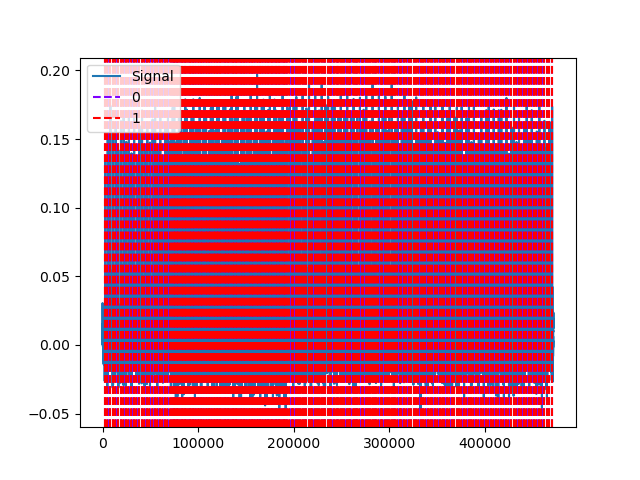

In [13]:
%matplotlib widget
# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([_rpeaks['ECG_R_Peaks'], 
                       waves_peak['ECG_P_Peaks']], cc0)

In [15]:
ppks = remove_nans(waves_peak['ECG_P_Peaks'])
ecgfile['P_peaks'] = np.nan
ecgfile.loc[ppks, 'P_peaks'] = 1

## Circular phase plot

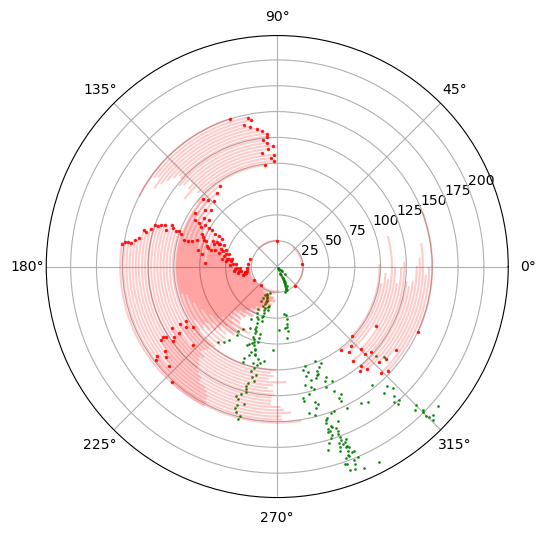

In [17]:
%matplotlib inline
rpeaks = ecgfile.query('ECG_peaks == 1').index.tolist()
rads = genPhaseData(ecgfile, rpeaks ) #b.query('ECG_peaks == 1').index.tolist()

fig = plt.figure(figsize = (6, 6))
plt.axes(projection='polar')

p4p = rads.query('type == "p"')

plt.polar(p4p.phase/180*np.pi, p4p.i, 'go', ms=1, alpha = 0.8)

l4p = rads.query('type == "laser"')

plt.polar(l4p.phase/180*np.pi, l4p.i, 'ro', ms=1.5, alpha = 0.8)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = l4p.loc[i].phase
    per = l4p.loc[i].period
    the = thb + 33/per*360
    bn = l4p.loc[i].i
    plt.polar(np.linspace(thb, the, 100)/180*np.pi, [bn]*100, 'r-', ms=1.5, alpha=.2)

# for i in l4p.i:
#     thb = l4p.query('i == '+str(i)).iloc[0,2]
#     the = thb + 33/l4p.query('i == '+str(i)).iloc[0,3]*360 # e4p.query('i =='+str(i)).iloc[0,2]
#     print(i, thb, the)
#     plt.polar(np.linspace(thb, the, 100)/180*np.pi, [i]*100, 'r-', ms=1.5, alpha = 0.2)

#plt.title(f'File №122') # 

## Linear phase plot

In [18]:
import scienceplots
plt.style.use(['science','nature'])
import matplotlib
matplotlib.rc('axes', linewidth=1)
lp_wline = .3
hz_wline = 1.0

### From previous R-peak

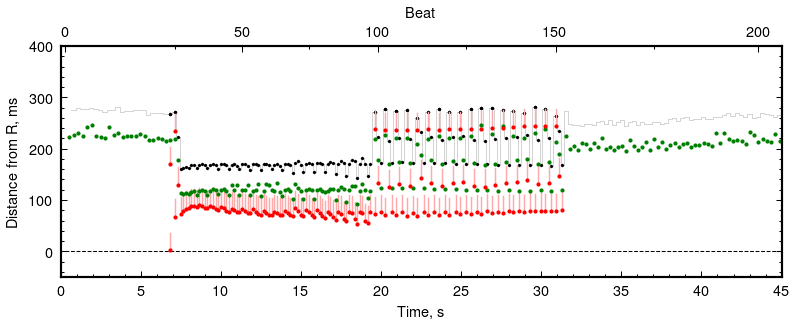

In [21]:
b = ecgfile
rpeaks = b.query('ECG_peaks == 1')['Time_s'].to_numpy()
spticks = list(zip(rpeaks, list(range(len(rpeaks)))))
spticks_ = pd.DataFrame(spticks)
p4p = rads.query('type == "p"').copy()
def addTopY(ax):
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([i for i,j in spticks if j % 25 == 0], minor=True)
    ax2.set_xticks([i for i,j in spticks if j % 50 == 0], minor=False)
    ax2.set_xticklabels([j for i,j in spticks if j % 50 == 0], minor=False)
    ax2.xaxis.set_tick_params(which='minor',top=True)
    ax2.set_xlabel('Beat')

fig, ax = plt.subplots(1,1, figsize = (6.2, 2), dpi=150)    

cax = ax

p4p = p4p.query('abs(phase) > 10')
cax.plot(spticks_.loc[p4p.i,0], 
        ((p4p.phase+360).astype('int') % 360)/360*p4p.period, 
         'go', ms=1, zorder = 3)
l4p = rads.query('type == "laser"')
cax.plot(spticks_.loc[l4p.i,0], 
         ((l4p.phase+360).astype('int') % 360)/360*l4p.period, 
         'ro', ms=1, zorder = 3)
cax.plot(spticks_.loc[l4p.i,0], 
         l4p.period, 
         'kx', ms=1, zorder = 2)

plt.step(rpeaks[1:]+.1, np.diff(rpeaks)*1000, 
         '-k', lw=.4, zorder = 1, alpha=.2)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = ((l4p.loc[i, 'phase']*10).astype('int') + 3600) % 3600
    thb /= 10
    per = l4p.loc[i, 'period']
    the = thb + 33/per*360
    nb = l4p.loc[i, 'i']
    # print(nb, thb, the, per)
    cax.plot([spticks_.loc[nb,0]]*2, 
             np.array([thb, the])/360*per, '-', 
             color='#ffaaaa', lw=0.7, zorder=2)
cax.hlines(0, rpeaks[0], rpeaks[-1], linestyles='--', lw=0.5, color='k')
# cax.set_xlim(rpeaks[0],rpeaks[-1])
cax.set_xlim(0, 45)
cax.set_ylim(-50, 400)
cax.set_ylabel('Distance from R, ms')
cax.set_xlabel('Time, s')
addTopY(cax)

# plt.savefig('phasePlot.pdf')

### From next R-peak

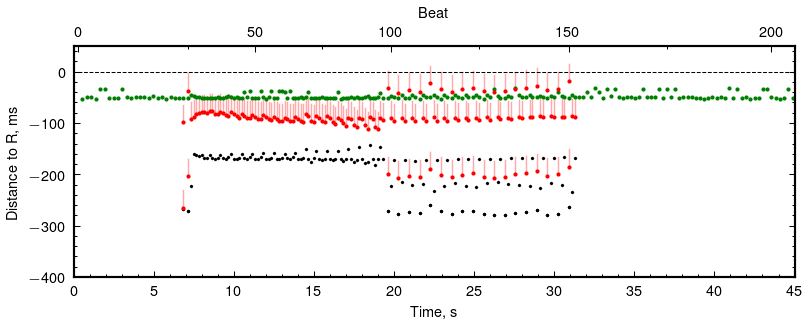

In [22]:
b = ecgfile
rpeaks = b.query('ECG_peaks == 1')['Time_s'].to_numpy()
spticks = list(zip(rpeaks, list(range(len(rpeaks)))))
spticks_ = pd.DataFrame(spticks)
p4p = rads.query('type == "p"').copy()
def addTopY(ax):
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([i for i,j in spticks if j % 25 == 0], minor=True)
    ax2.set_xticks([i for i,j in spticks if j % 50 == 0], minor=False)
    ax2.set_xticklabels([j for i,j in spticks if j % 50 == 0], minor=False)
    ax2.xaxis.set_tick_params(which='minor',top=True)
    ax2.set_xlabel('Beat')

fig, ax = plt.subplots(1,1, figsize = (6.2, 2), dpi=150)    

cax = ax

p4p = p4p.query('abs(phase) > 10')
cax.plot(spticks_.loc[p4p.i,0], 
        ((p4p.phase+360).astype('int') % 360 - 360)/360*p4p.period, 
         'go', ms=1, zorder = 3)
l4p = rads.query('type == "laser"')
cax.plot(spticks_.loc[l4p.i,0], 
         ((l4p.phase+360).astype('int') % 360 - 360)/360*l4p.period, 
         'ro', ms=1, zorder = 3)
cax.plot(spticks_.loc[l4p.i,0], 
         -l4p.period, 
         'kx', ms=1, zorder = 2)

#plt.step(rpeaks[1:]+.1, -np.diff(rpeaks)*1000, 
#         '-k', lw=.4, zorder = 1, alpha=.2)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = ((l4p.loc[i, 'phase']*10).astype('int') + 3600) % 3600
    thb /= 10
    per = l4p.loc[i, 'period']
    the = thb + 33/per*360
    nb = l4p.loc[i, 'i']
    # print(nb, thb, the, per)
    cax.plot([spticks_.loc[nb,0]]*2, 
             np.array([thb, the])/360*per - per, '-', 
             color='#ffaaaa', lw=0.7, zorder=2)
cax.hlines(0, rpeaks[0], rpeaks[-1], linestyles='--', lw=0.5, color='k')
# cax.set_xlim(rpeaks[0],rpeaks[-1])
cax.set_xlim(0, 45)
cax.set_ylim(-400, 50)
cax.set_ylabel('Distance to R, ms')
cax.set_xlabel('Time, s')
addTopY(cax)

# plt.savefig('phasePlot_fromNext.pdf')

## Linear phase & ECG (zoomed in)

### From previous R-peak

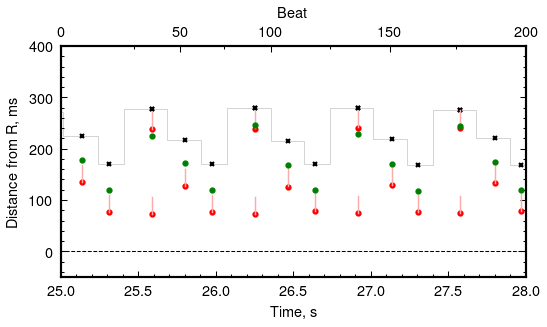

In [23]:
fig, ax = plt.subplots(1,1, figsize = (4, 2), dpi=150)    

cax = ax

p4p = p4p.query('abs(phase) > 10')
cax.plot(spticks_.loc[p4p.i,0], 
        ((p4p.phase+360).astype('int') % 360)/360*p4p.period, 
         'go', ms=2, zorder = 3)
l4p = rads.query('type == "laser"')
cax.plot(spticks_.loc[l4p.i,0], 
         ((l4p.phase+360).astype('int') % 360)/360*l4p.period, 
         'ro', ms=2, zorder = 2)
cax.plot(spticks_.loc[l4p.i,0], 
         l4p.period, 
         'kx', ms=2, zorder = 2)

plt.step(rpeaks[1:]+.1, np.diff(rpeaks)*1000, 
         '-k', lw=.4, zorder = 1, alpha=.2)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = ((l4p.loc[i, 'phase']*10).astype('int') + 3600) % 3600
    thb /= 10
    per = l4p.loc[i, 'period']
    the = thb + 33/per*360
    nb = l4p.loc[i, 'i']
    # print(nb, thb, the, per)
    cax.plot([spticks_.loc[nb,0]]*2, 
             np.array([thb, the])/360*per, '-', 
             color='#ffaaaa', lw=0.7, zorder=2)
cax.hlines(0, rpeaks[0], rpeaks[-1], linestyles='--', lw=0.5, color='k')
# cax.set_xlim(rpeaks[0],rpeaks[-1])
cax.set_xlim(25, 28)
cax.set_ylim(-50, 400)
cax.set_ylabel('Distance from R, ms')
cax.set_xlabel('Time, s')
addTopY(cax)

# plt.savefig('phasePlotZoom.pdf')

### From next R-peak

In [24]:
spticks_.loc[p4p.i,0] #+ p_positions / 1e3

1       0.5421
2       0.8180
3       1.0969
4       1.3741
5       1.6515
        ...   
209    45.9452
210    46.2081
211    46.4722
212    46.7414
213    47.0185
Name: 0, Length: 213, dtype: float64

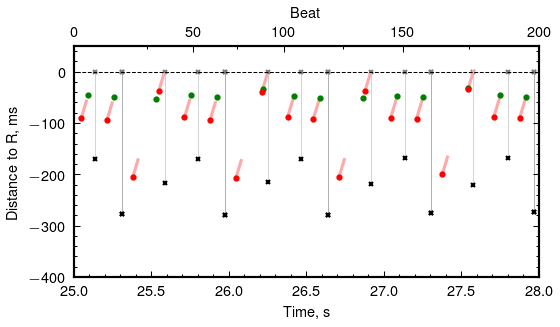

In [25]:
fig, ax = plt.subplots(1,1, figsize = (4, 2), dpi=150)    

cax = ax

p4p = p4p.query('abs(phase) > 10')
p_positions = ( ((p4p.phase+360).astype('int') % 360-360)/360*p4p.period ).to_numpy()
cax.plot(spticks_.loc[p4p.i,0].to_numpy() + p_positions/1e3, 
         p_positions, 
         'go', ms=2, zorder = 3)
l4p = rads.query('type == "laser"')
ls_positions = (((l4p.phase+360).astype('int') % 360-360)/360*l4p.period).to_numpy()
cax.plot(spticks_.loc[l4p.i,0].to_numpy() + ls_positions/1e3, 
         ls_positions,
         'ro', ms=2, zorder = 3)
cax.plot(spticks_.loc[l4p.i-1,0], 
         -l4p.period, 
         'kx', ms=2, zorder = 2)
cax.plot(spticks_.loc[l4p.i-1,0], 
         l4p.period*0, 
         'x', color='gray', ms=2, zorder = 2)
for i in l4p.index:
    t_ = spticks_.loc[l4p.loc[i,'i']-1,0]
    cax.plot([t_,t_], [-l4p.loc[i, 'period'], 0],
             '-k', lw=.4, zorder = 1, alpha=.2)
#plt.step(rpeaks[1:], -np.diff(rpeaks)*1000, 
#         '-k', lw=.4, zorder = 1, alpha=.2)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = ((l4p.loc[i, 'phase']*10).astype('int') + 3600) % 3600
    thb /= 10
    per = l4p.loc[i, 'period']
    the = thb + 33/per*360
    nb = l4p.loc[i, 'i']
    # print(nb, thb, the, per)
    cax.plot( np.array([thb, the])/360*per/1000 - per/1000 + spticks_.loc[nb,0], 
             np.array([thb, the])/360*per - per, '-', 
             color='#ffaaaa', lw=1.5, zorder=2)
cax.hlines(0, rpeaks[0], rpeaks[-1], linestyles='--', lw=0.5, color='k')
# cax.set_xlim(rpeaks[0],rpeaks[-1])
cax.set_xlim(25, 28)
cax.set_ylim(-400, 50)
cax.set_ylabel('Distance to R, ms')
cax.set_xlabel('Time, s')
addTopY(cax)

# plt.savefig('phasePlotZoom_fromNext.pdf')

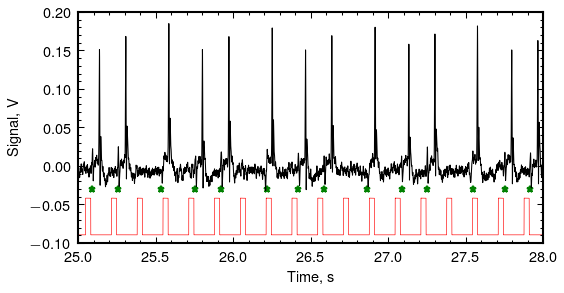

In [27]:
fig, ax = plt.subplots(1,1, figsize = (4, 2), dpi=150)  
ax.plot(ecgfile.iloc[:,0], cc0, '-k', lw=0.5, zorder=3)
ax.plot(ecgfile.iloc[:,0], 
        ecgfile.Laser_V*.02 - .09, '-r', lw=.3, zorder=1)
ax.plot(
    ecgfile.iloc[waves_peak['ECG_P_Peaks'], 0], 
    [-0.03]*len(waves_peak['ECG_P_Peaks']), 'g*')
ax.set_xlim(25,28)
ax.set_ylim(-0.1,0.2)
ax.set_ylabel('Signal, V')
ax.set_xlabel('Time, s')
plt.savefig('ECGZoom.pdf')

In [140]:
# dont need it here
# _, rpeaks = nk.ecg_peaks(b.ECG_ch1, sampling_rate=5000)
# plot = nk.events_plot(rpeaks['ECG_R_Peaks'], -b.ECG_ch1_dns)

## Circular phase plot

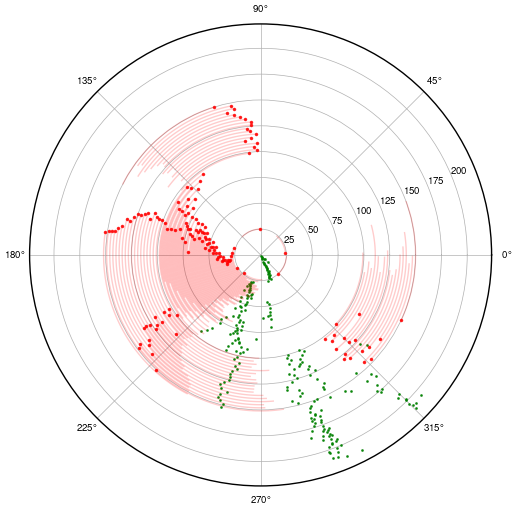

In [28]:
%matplotlib inline
rads = genPhaseData(ecgfile, _rpeaks['ECG_R_Peaks'] ) #b.query('ECG_peaks == 1').index.tolist()

fig = plt.figure(figsize = (6, 6))
plt.axes(projection='polar')    

p4p = rads.query('type == "p"')

plt.polar(p4p.phase/180*np.pi, p4p.i, 'go', ms=1, alpha = 0.8)

l4p = rads.query('type == "laser"')

plt.polar(l4p.phase/180*np.pi, l4p.i, 'ro', ms=1.5, alpha = 0.8)

e4p = rads.query('type == "lasend"')
for i in l4p.index:
    thb = l4p.loc[i].phase
    per = l4p.loc[i].period
    the = thb + 33/per*360
    bn = l4p.loc[i].i
    plt.polar(np.linspace(thb, the, 100)/180*np.pi, [bn]*100, 'r-', ms=1.5, alpha=.2)

# for i in l4p.i:
#     thb = l4p.query('i == '+str(i)).iloc[0,2]
#     the = thb + 33/l4p.query('i == '+str(i)).iloc[0,3]*360 # e4p.query('i =='+str(i)).iloc[0,2]
#     print(i, thb, the)
#     plt.polar(np.linspace(thb, the, 100)/180*np.pi, [i]*100, 'r-', ms=1.5, alpha = 0.2)

#plt.title(f'File №122') # 

## Poincare plot

In [30]:

# получить датасет, получить тип файла
thisfile =  ecgfile

# индексы точек с началом стимуляции
l_indexes = thisfile[thisfile['Las_peaks'] == 1].index.tolist()
las_period = l_indexes[3] - l_indexes[2]
#получить частоту лазера ГЦ


phases_df = pd.DataFrame(columns = ['stimul_idx', 'Time_s',  'phi'])

for las_idx in l_indexes:       


    # ищем пик до
    ecg_idx = las_idx
    while (ecg_idx > 1  and 
           thisfile.loc[ecg_idx, 'ECG_peaks'] != 1 and 
           ecg_idx > las_idx - las_period):

        ecg_idx -= 1

    ecg_peak_idx0 = ecg_idx 

    # ищем пик после
    ecg_idx =  las_idx
    while (ecg_idx < thisfile.shape[0] and  
           thisfile.loc[ecg_idx, 'ECG_peaks'] != 1 and 
           ecg_idx < las_idx + las_period):
        ecg_idx += 1

    ecg_peak_idx1 = ecg_idx

    # получит T

    T = (ecg_peak_idx1 - ecg_peak_idx0)/10000
    delta = (las_idx - ecg_peak_idx0)/10000

    if delta < T/2: # стимул ближе к предыдущему пику
        phi = delta/T
    elif delta > T/2:
        phi = (delta- T) / T

    #добавить это добро в ДФ
    phases_temp = pd.DataFrame([[las_idx, thisfile.loc[las_idx, 'Time_s'], phi]], columns = ['stimul_idx', 'Time_s',  'phi'])
    phases_df = pd.concat([phases_df, phases_temp], axis = 0, ignore_index = True)

# отсортировать по индексам стимулов
phases_df.sort_values(['stimul_idx'],  axis=0, inplace = True)
phases_df.reset_index(drop=True, inplace = True)



/tmp/ipykernel_132862/2434021265.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  phases_df = pd.concat([phases_df, phases_temp], axis = 0, ignore_index = True)


In [33]:
def plot_chaos(data, t_chstart):
    rts = data.query('ECG_peaks == 1').iloc[:,0].to_numpy()
    apa = rts[1:] - rts[:-1] 
    lamerey = np.zeros( ((apa.shape[0]-1)*2, 2) )
    # even lines
    lamerey[0::2, :] = np.vstack([apa[:-1],  apa[1:]]).T
    # odd lines\
    lamerey[1::2, :] = np.vstack([apa[1:],  apa[1:]]).T

    t_lstart = data.query('Las_peaks == 1').iloc[0]['Time_s']
    i_lstart = rts.searchsorted(t_lstart)

    i_chstart = rts.searchsorted(t_chstart)

    t_lstop = data.query('Las_peaks == 1').iloc[-1]['Time_s']
    i_lstop = rts.searchsorted(t_lstop)

    apa_0 = apa[:i_lstart]
    apa_1 = apa[i_lstart:i_chstart]
    apa_2 = apa[i_chstart:i_lstop]
    lamerey_0 = lamerey[:i_lstart*2]
    lamerey_2 = lamerey[i_chstart*2:i_lstop*2]
    lamerey_1 = lamerey[i_lstart*2:i_chstart*2]
    plt.plot(apa_0[:-1],  apa_0[1:], 'o', color='gray', label='Control', alpha = 0.5, mec='k')
    plt.plot(apa_1[:-1],  apa_1[1:], 'ob', label='Induced', alpha = 0.5, mec='k')
    plt.plot(apa_2[:-1],  apa_2[1:], 'or', label='Prechaotic', alpha = 0.5, mec='k')
    plt.plot(lamerey_0[:,0], lamerey_0[:,1], '-', color='gray', alpha=0.2)
    plt.plot(lamerey_2[:,0], lamerey_2[:,1], '-r', alpha=0.2)
    plt.plot(lamerey_1[:,0], lamerey_1[:,1], '-b', alpha=0.2)
    plt.xlim(0.1,0.35)
    plt.ylim(0.1,0.35)
    plt.plot([0,0.4], [0,0.4], '--', color='gray')
    plt.xlabel('N Period, sec')
    plt.ylabel('N+1 Period, sec')
    plt.legend()

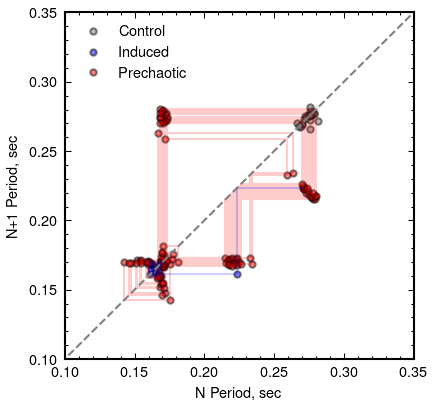

In [34]:
fig = plt.figure(figsize = (3, 3), dpi=150)
plot_chaos(ecgfile, 11)
# plt.savefig('poincarePlot.pdf')